In [107]:
import torch
import torch.nn as nn
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
torch.manual_seed(0)

In [97]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    transforms.RandomPerspective(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [98]:
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indices)

In [99]:
# Define hyperparameters
epochs = 150
batch_size = 64
lr = 0.001
lambda_reg = 0.0001

In [100]:
# Load dataset with augmentations
dataset = datasets.ImageFolder(root="train/train")

mapping = {str(i): i for i in range(100)}
dataset.class_to_idx = mapping
for idx in range(len(dataset.targets)):
    old_class = dataset.classes[dataset.targets[idx]]
    dataset.targets[idx] = mapping[old_class]

# Define training / test split ratio
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_indices, val_indices = random_split(range(len(dataset)), [train_size, val_size])

train_dataset = TransformedSubset(dataset, train_indices, train_transform)
val_dataset = TransformedSubset(dataset, val_indices, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [101]:
model = convnext_large(weights=ConvNeXt_Large_Weights.DEFAULT)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False  

# Unfreeze last 2 layers and classifier
for param in model.features[-2].parameters():
    param.requires_grad = True

for param in model.features[-1].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

# Change classifier to output 100 classes
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, 100)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=lambda_reg)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [102]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        

        self.cutmix = v2.CutMix(num_classes=100)
        self.mixup = v2.MixUp(num_classes=100)
        self.cutmix_or_mixup = v2.RandomChoice([self.cutmix, self.mixup])
        

    def train(self, epochs=10):
        losses_train, losses_val = [], []
        accs_train = []
        accs_val = []

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            for x_train, y_train in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                x_train, y_train = self.cutmix_or_mixup(x_train, y_train)
                x_train, y_train = x_train.to(self.device), y_train.to(self.device)

                # Forward pass
                self.optimizer.zero_grad()
                y_pred = self.model(x_train)
                loss = self.criterion(y_pred, y_train)

                # Backward pass
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                _, predicted = y_pred.max(1)
                total += y_train.size(0)
        
                _, ground_truth = y_train.max(1)
                correct += predicted.eq(ground_truth).sum().item()

            train_acc = 100. * (correct / total)
            val_loss, val_acc = self.evaluate()

            loss_train = epoch_loss / len(self.train_loader)
            losses_train.append(loss_train)
            losses_val.append(val_loss)
            accs_val.append(val_acc)
            accs_train.append(train_acc)
            self.scheduler.step()

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss/len(self.train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        return losses_train, losses_val, accs_train, accs_val
    
    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for x_val, y_val in self.val_loader:
                x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                y_pred = self.model(x_val)
                loss = self.criterion(y_pred, y_val)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = y_pred.max(1)
                total += y_val.size(0)
                correct += predicted.eq(y_val).sum().item()
        
        val_acc = 100. * correct / total
        return val_loss / len(self.val_loader), val_acc

In [103]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

# Train model
losses_train, losses_val, accs_train, accs_val = trainer.train(epochs=epochs)

Epoch 1/25: 100%|██████████| 16/16 [01:46<00:00,  6.67s/it]


Epoch 1/25 | Train Loss: 4.4414 | Train Acc: 4.30% | Val Loss: 2.8656 | Val Acc: 0.00%


Epoch 2/25: 100%|██████████| 16/16 [01:47<00:00,  6.73s/it]


Epoch 2/25 | Train Loss: 3.7426 | Train Acc: 14.51% | Val Loss: 2.6159 | Val Acc: 0.00%


Epoch 3/25: 100%|██████████| 16/16 [01:45<00:00,  6.57s/it]


Epoch 3/25 | Train Loss: 3.5402 | Train Acc: 21.62% | Val Loss: 1.8762 | Val Acc: 100.00%


Epoch 4/25: 100%|██████████| 16/16 [01:44<00:00,  6.54s/it]


Epoch 4/25 | Train Loss: 3.3687 | Train Acc: 25.83% | Val Loss: 2.0404 | Val Acc: 0.00%


Epoch 5/25: 100%|██████████| 16/16 [01:42<00:00,  6.40s/it]


Epoch 5/25 | Train Loss: 3.2564 | Train Acc: 29.73% | Val Loss: 2.1752 | Val Acc: 100.00%


Epoch 6/25: 100%|██████████| 16/16 [01:45<00:00,  6.60s/it]


Epoch 6/25 | Train Loss: 2.7838 | Train Acc: 39.94% | Val Loss: 2.9095 | Val Acc: 0.00%


Epoch 7/25: 100%|██████████| 16/16 [01:47<00:00,  6.69s/it]


Epoch 7/25 | Train Loss: 2.9989 | Train Acc: 35.14% | Val Loss: 1.1729 | Val Acc: 100.00%


Epoch 8/25: 100%|██████████| 16/16 [01:44<00:00,  6.55s/it]


Epoch 8/25 | Train Loss: 2.8472 | Train Acc: 40.24% | Val Loss: 0.9888 | Val Acc: 0.00%


Epoch 9/25: 100%|██████████| 16/16 [01:42<00:00,  6.39s/it]


Epoch 9/25 | Train Loss: 2.5616 | Train Acc: 51.75% | Val Loss: 1.3561 | Val Acc: 0.00%


Epoch 10/25: 100%|██████████| 16/16 [01:43<00:00,  6.46s/it]


Epoch 10/25 | Train Loss: 2.5465 | Train Acc: 52.75% | Val Loss: 2.2490 | Val Acc: 0.00%


Epoch 11/25: 100%|██████████| 16/16 [01:42<00:00,  6.41s/it]


Epoch 11/25 | Train Loss: 2.4016 | Train Acc: 53.25% | Val Loss: 1.0086 | Val Acc: 100.00%


Epoch 12/25: 100%|██████████| 16/16 [01:42<00:00,  6.38s/it]


Epoch 12/25 | Train Loss: 2.6159 | Train Acc: 52.75% | Val Loss: 0.9248 | Val Acc: 100.00%


Epoch 13/25: 100%|██████████| 16/16 [01:41<00:00,  6.37s/it]


Epoch 13/25 | Train Loss: 2.3010 | Train Acc: 55.56% | Val Loss: 1.6989 | Val Acc: 0.00%


Epoch 14/25: 100%|██████████| 16/16 [01:42<00:00,  6.41s/it]


Epoch 14/25 | Train Loss: 2.5520 | Train Acc: 55.06% | Val Loss: 0.9775 | Val Acc: 100.00%


Epoch 15/25: 100%|██████████| 16/16 [01:42<00:00,  6.40s/it]


Epoch 15/25 | Train Loss: 2.3134 | Train Acc: 57.86% | Val Loss: 2.0639 | Val Acc: 0.00%


Epoch 16/25: 100%|██████████| 16/16 [01:42<00:00,  6.38s/it]


Epoch 16/25 | Train Loss: 2.4733 | Train Acc: 55.16% | Val Loss: 1.3375 | Val Acc: 0.00%


Epoch 17/25: 100%|██████████| 16/16 [01:43<00:00,  6.46s/it]


Epoch 17/25 | Train Loss: 2.3707 | Train Acc: 58.16% | Val Loss: 1.0065 | Val Acc: 0.00%


Epoch 18/25: 100%|██████████| 16/16 [01:45<00:00,  6.62s/it]


Epoch 18/25 | Train Loss: 2.2598 | Train Acc: 62.16% | Val Loss: 1.5806 | Val Acc: 0.00%


Epoch 19/25: 100%|██████████| 16/16 [01:43<00:00,  6.44s/it]


Epoch 19/25 | Train Loss: 2.5453 | Train Acc: 54.35% | Val Loss: 1.8849 | Val Acc: 0.00%


Epoch 20/25: 100%|██████████| 16/16 [01:42<00:00,  6.43s/it]


Epoch 20/25 | Train Loss: 2.2249 | Train Acc: 59.96% | Val Loss: 1.1674 | Val Acc: 0.00%


Epoch 21/25: 100%|██████████| 16/16 [01:42<00:00,  6.39s/it]


Epoch 21/25 | Train Loss: 2.2602 | Train Acc: 60.86% | Val Loss: 1.1554 | Val Acc: 0.00%


Epoch 22/25: 100%|██████████| 16/16 [01:42<00:00,  6.42s/it]


Epoch 22/25 | Train Loss: 2.0608 | Train Acc: 66.97% | Val Loss: 1.0648 | Val Acc: 0.00%


Epoch 23/25: 100%|██████████| 16/16 [01:42<00:00,  6.43s/it]


Epoch 23/25 | Train Loss: 2.1529 | Train Acc: 64.66% | Val Loss: 0.9867 | Val Acc: 0.00%


Epoch 24/25: 100%|██████████| 16/16 [01:43<00:00,  6.47s/it]


Epoch 24/25 | Train Loss: 2.2066 | Train Acc: 61.86% | Val Loss: 1.0252 | Val Acc: 0.00%


Epoch 25/25: 100%|██████████| 16/16 [01:42<00:00,  6.41s/it]

Epoch 25/25 | Train Loss: 2.3450 | Train Acc: 56.76% | Val Loss: 1.0177 | Val Acc: 0.00%


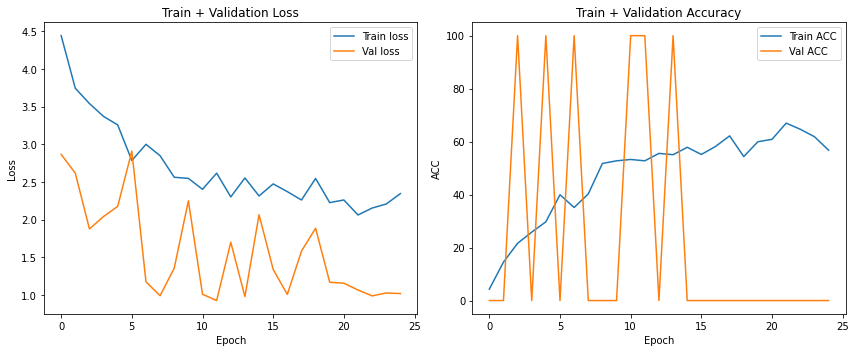

In [104]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].plot(np.arange(epochs), losses_train, label="Train loss")
axes[0].plot(np.arange(epochs), losses_val, label="Val loss")
axes[0].set_title("Train + Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(np.arange(epochs), accs_train, label="Train ACC")
axes[1].plot(np.arange(epochs), accs_val, label="Val ACC")
axes[1].set_title("Train + Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("ACC")
axes[1].legend()

plt.tight_layout()
plt.show()

In [105]:
from PIL import Image

# Create test transform (same as validation transform)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')], 
                               key=lambda x: int(x.split('.')[0]))  # Sort by numeric ID
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image) 
        return image, self.img_names[idx]

test_dataset = TestDataset(img_dir="test/", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()

predictions = []

integers = list(range(0, 100))
string_versions = [str(i) for i in integers]
alphabetically_sorted = sorted(string_versions)
# Create the mapping: {original_integer: alphabetical_position}
mapping = {i: int(alphabetically_sorted[i]) for i in range(len(alphabetically_sorted))}

with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc="Generating predictions"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for filename, pred in zip(filenames, predicted.cpu().numpy()):
            predictions.append((filename, mapping[int(pred)]))

predictions.sort(key=lambda x: int(x[0].split('.')[0]))

with open('predictions.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['ID', 'Label'])  # Header
    
    for filename, label in predictions:
        csv_writer.writerow([filename, label])


Generating predictions: 100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


In [106]:
# Uncomment to save the model's state dictionary
# torch.save(model.state_dict(), 'model_weights.pth')